# Generative Learning Networks (GANs)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Generative Adversarial Networks

* make neural networks **compete against each other** in the hope that this competition will push them to excel

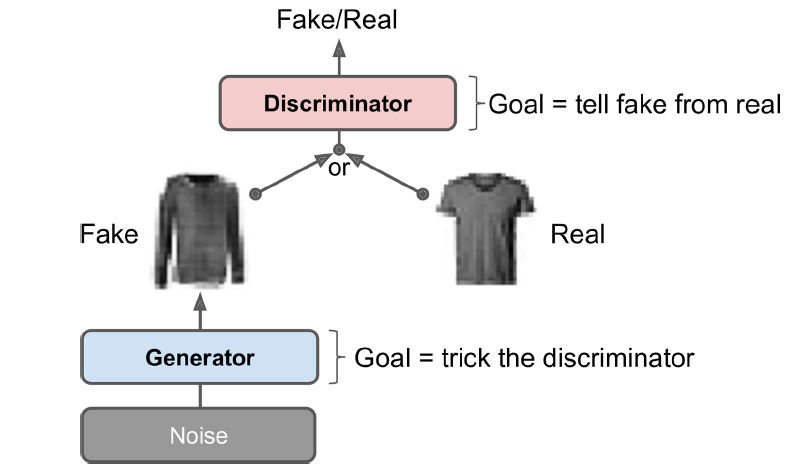


***Generator***

* Takes a **random distribution as input (typically Gaussian)** and outputs some data—typically, an image.
* You can think of the random inputs **as the latent representations (i.e., codings)** of the image to be generated.
* **the generator offers the same functionality as a decoder in a variational autoencoder**, and it can be used in the same way to generate new images (just feed it some Gaussian noise, and it outputs a brand-new image).
* Goal: the generator tries to produce images that **look real enough to trick the discriminator**.


***Discriminator***

* Takes either a **fake image from the generator or a real image from the training set** as input, and must **guess whether the input image is fake or real**.

* Goal: the discriminator tries to **tell fake images from real images**

***Training***

Because the GAN is composed of two networks with different objectives, it cannot be trained like a regular neural network. Each training iteration is divided into two phases:

* Train the discriminator: 
    * A batch of **real images is sampled from the training set** and is completed with an equal number of **fake images produced by the generator**. 
    * The labels are set to **0 for fake images and 1 for real** images
    * the discriminator is trained on this labeled batch for one step, using the **binary cross-entropy loss**. 
    * Importantly, backpropagation only **optimizes the weights of the discriminator** during this phase.


* Train the generator:
    * We first use it to **produce another batch of fake images**, and once again **the discriminator is used to tell whether the images are fake or real.**
    * This time we do **not add real images in the batch**, and all the labels are set to 1 (real): in other words, we want the generator to produce images that the discriminator will (wrongly) believe to be real! 
    * Crucially, **the weights of the discriminator are frozen** during this step, so **backpropagation only affects the weights of the generator**.


## a simple GAN for Fashion MNIST

* The generator is similar to an autoencoder’s decoder

In [14]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

* discriminator is a regular binary classifier
* it takes an image as input and ends with a Dense layer containing a single unit and using the sigmoid activation function

In [15]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

* full GAN model containing the generator followed by the discriminator

In [16]:
gan = keras.models.Sequential([generator, discriminator])

***compile these models***

* As the **discriminator is a binary classifier**, we can naturally use the binary cross-entropy loss. 
* The **generator will only be trained through the gan model**, so we do not need to compile it at all
* The **gan model is also a binary classifier**, so it can use the binary cross-entropy loss. 
* Importantly, the discriminator should not be trained during the second phase, so we make it **non-trainable** before compiling the gan model


In [17]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

***Notes on the ```trainable``` attribute***

* the discriminator is **trainable if we call its fit() method or its train_on_batch() method**
* it is **not trainable when we call these methods on the gan model**.

* we cannot use the regular fit() method
* write a custom training loop
* create a Dataset to iterate through the images

In [18]:
from tensorflow import keras

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype( np.float32 )/255
X_test = X_test.astype( np.float32 )/255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [19]:
import matplotlib.pyplot as plt

def plot_multiple_images( images, n_cols=None ):
    n_cols = n_cols or len(images)
    n_rows = ( len(images)-1 )//n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze( images, axis=-1 )

    plt.figure( figsize=(n_cols, n_rows) )
    for index, image in enumerate(images):
        plt.subplot( n_rows, n_cols, index+1 )
        plt.imshow( image, cmap="binary" )
        plt.axis("off")

* write the training loop

In [20]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            
            #feed Gaussian noise to the generator to produce fake images
            generated_images = generator(noise) 
            
            # concatenating an equal number of real images
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            
            # The targets y1 are set to 0 for fake images and 1 for real images
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
                        
            # train the discriminator on this batch
            discriminator.trainable = True # disable warning
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            
            # feed the GAN some Gaussian noise
            noise = tf.random.normal(shape=[batch_size, codings_size])
            
            # We want the discriminator to believe that the fake images are real, so the targets y2 are set to 1
            y2 = tf.constant([[1.]] * batch_size)
            
            # set the trainable attribute to False
            discriminator.trainable = False
            
            # train gan
            gan.train_on_batch(noise, y2)
            
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


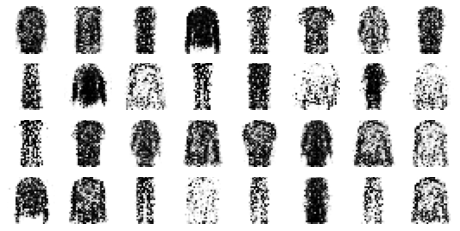

In [21]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

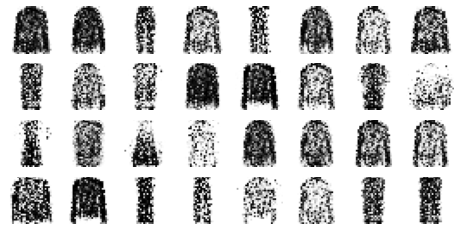

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
# save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


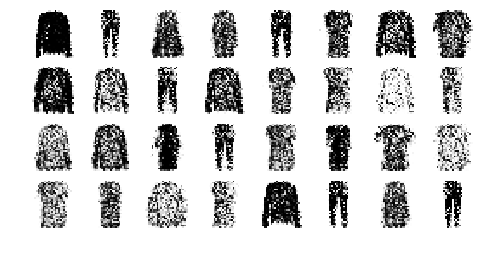

Epoch 2/50


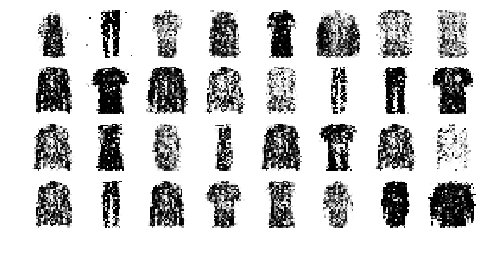

Epoch 3/50


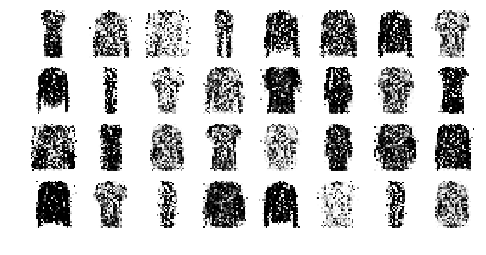

Epoch 4/50


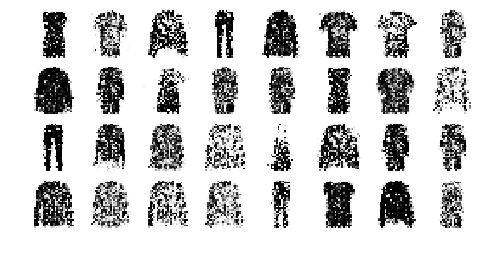

Epoch 5/50


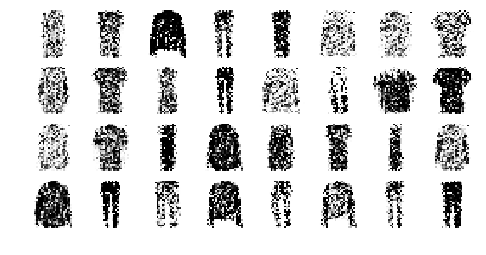

Epoch 6/50


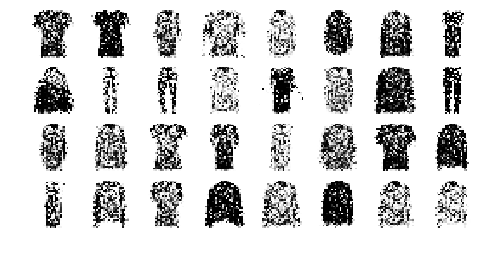

Epoch 7/50


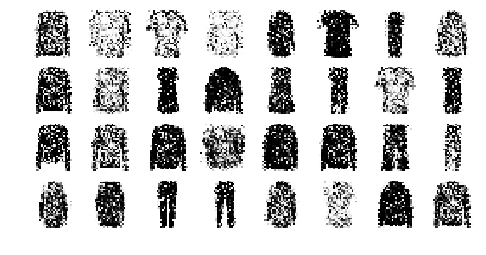

Epoch 8/50


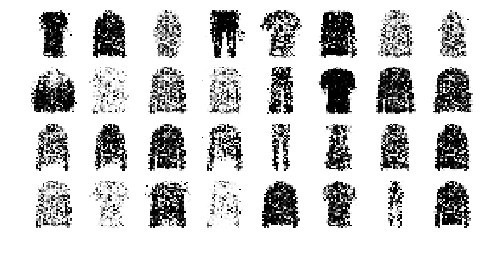

Epoch 9/50


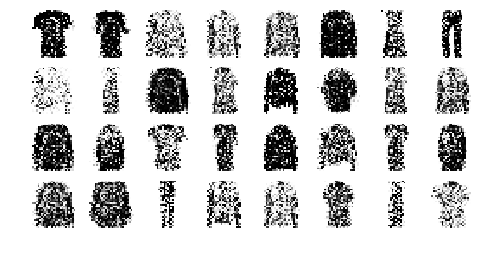

Epoch 10/50


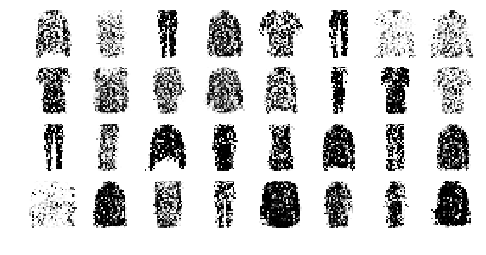

Epoch 11/50


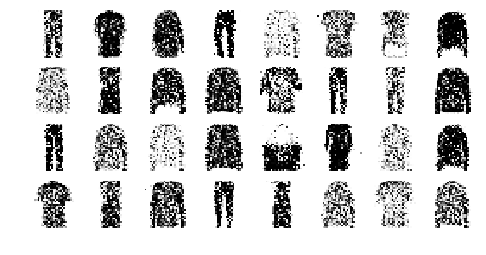

Epoch 12/50


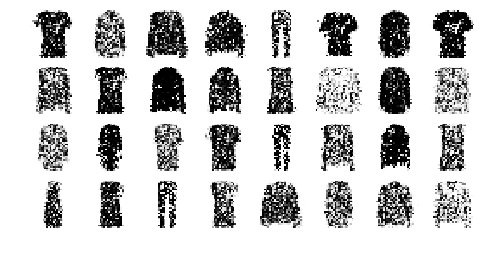

Epoch 13/50


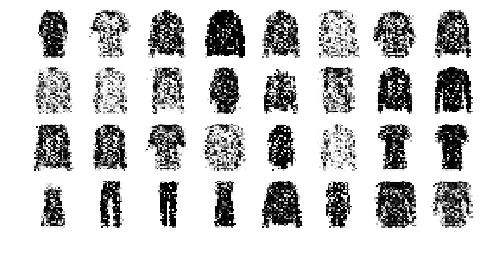

Epoch 14/50


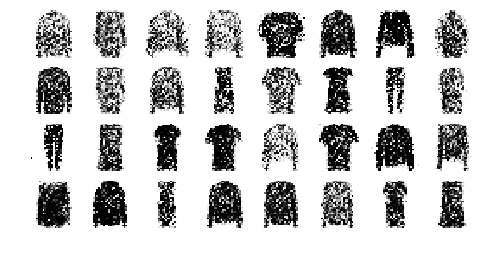

Epoch 15/50


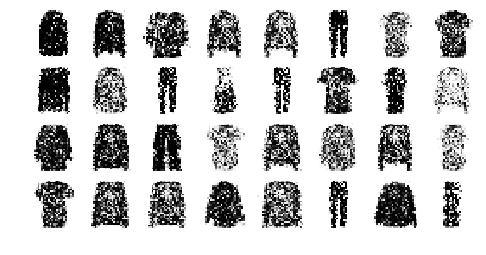

Epoch 16/50


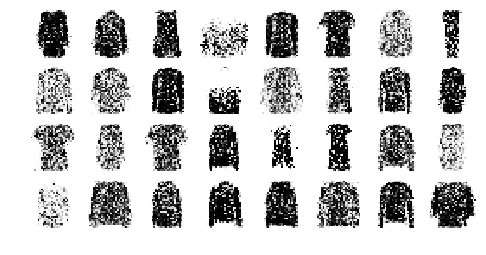

Epoch 17/50


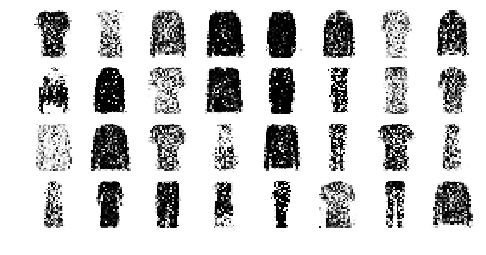

Epoch 18/50


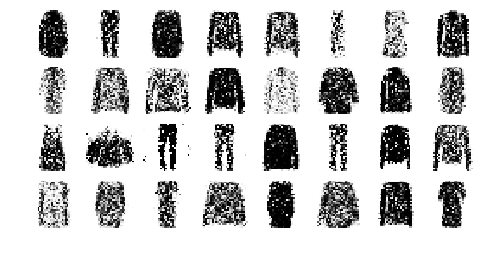

Epoch 19/50


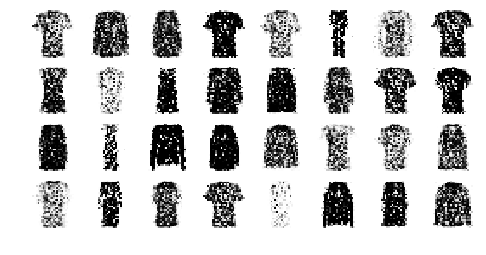

Epoch 20/50


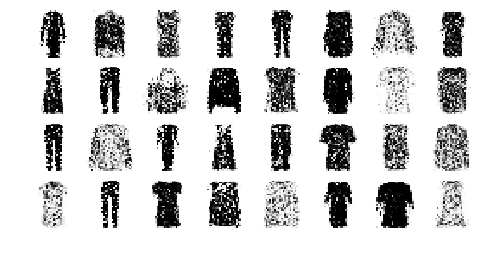

Epoch 21/50


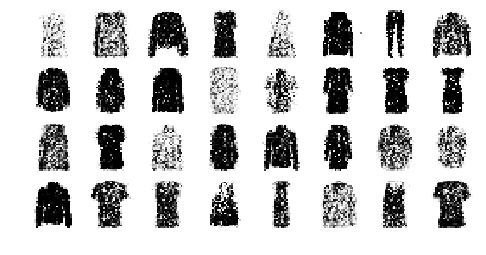

Epoch 22/50


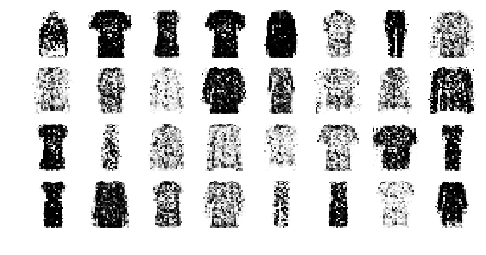

Epoch 23/50


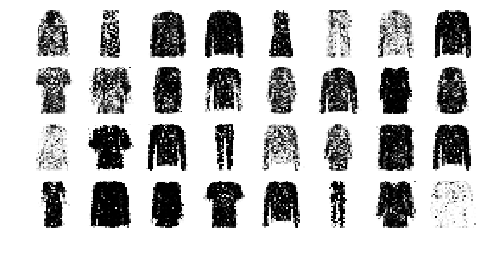

Epoch 24/50


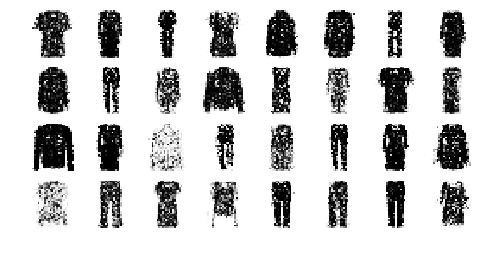

Epoch 25/50


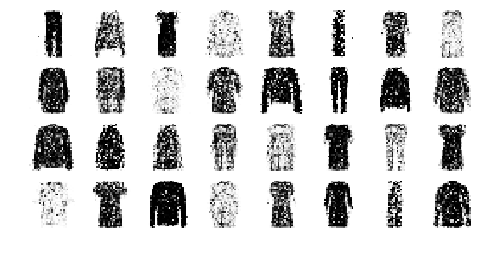

Epoch 26/50


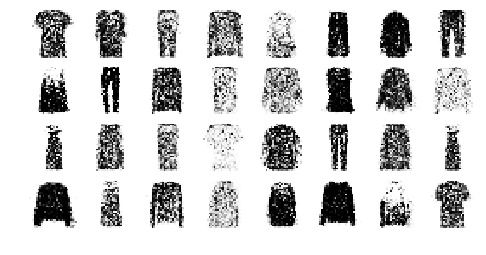

Epoch 27/50


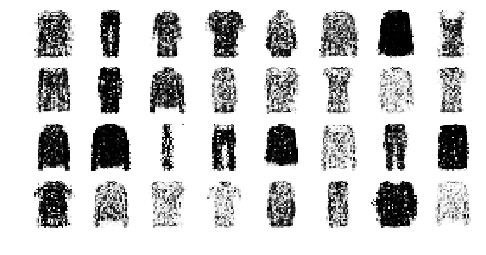

Epoch 28/50


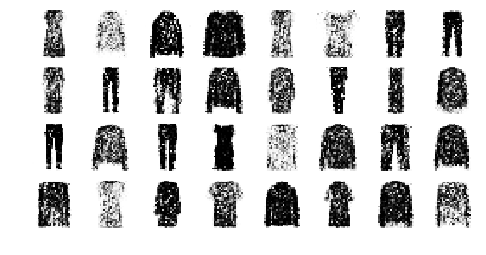

Epoch 29/50


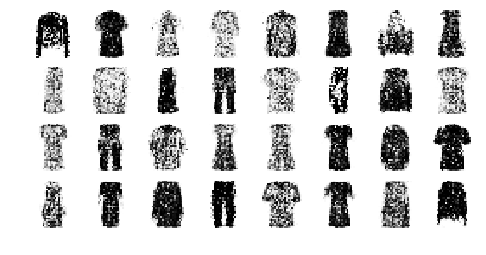

Epoch 30/50


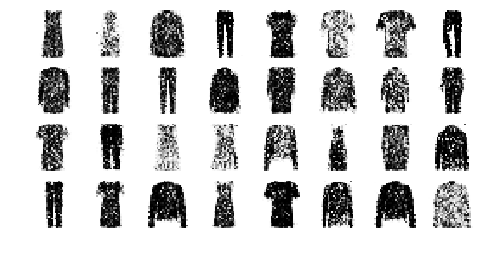

Epoch 31/50


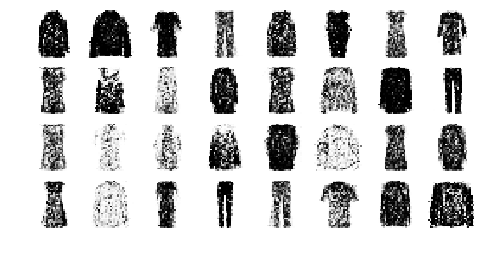

Epoch 32/50


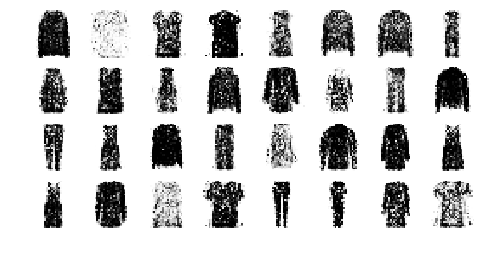

Epoch 33/50


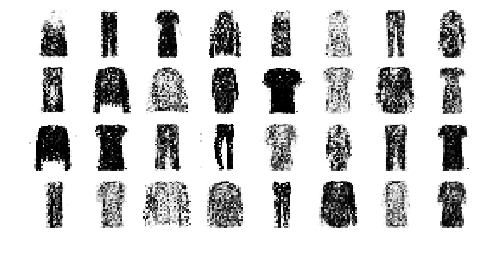

Epoch 34/50


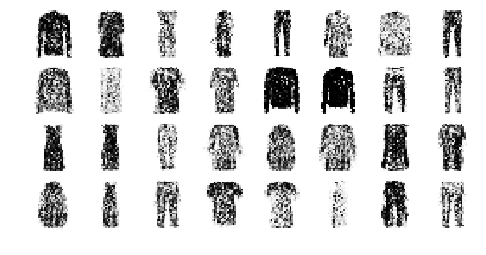

Epoch 35/50


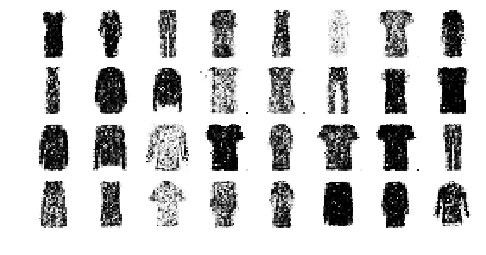

Epoch 36/50


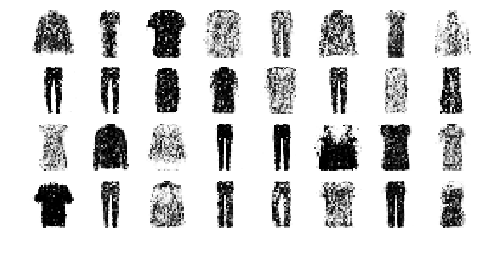

Epoch 37/50


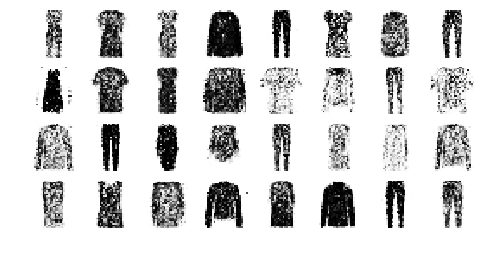

Epoch 38/50


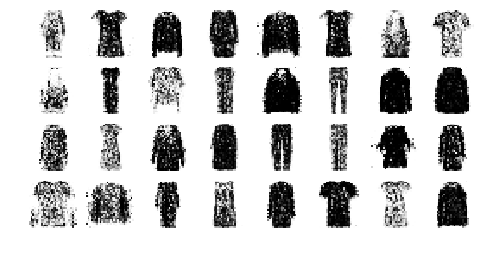

Epoch 39/50


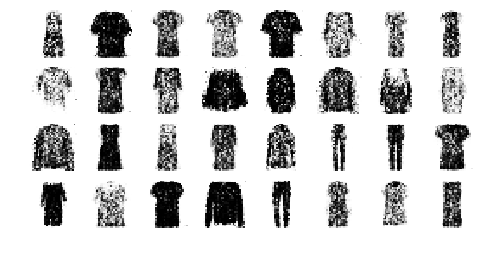

Epoch 40/50


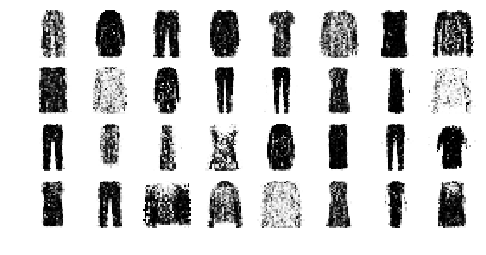

Epoch 41/50


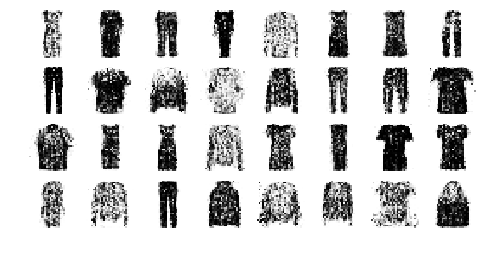

Epoch 42/50


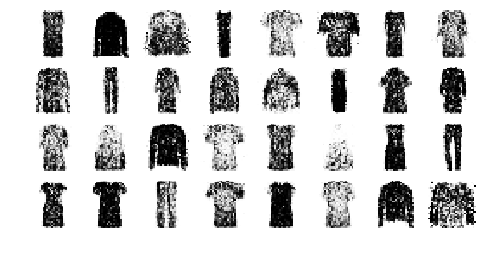

Epoch 43/50


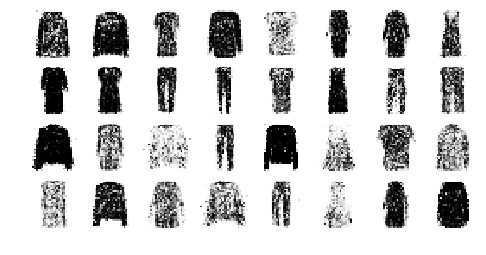

Epoch 44/50


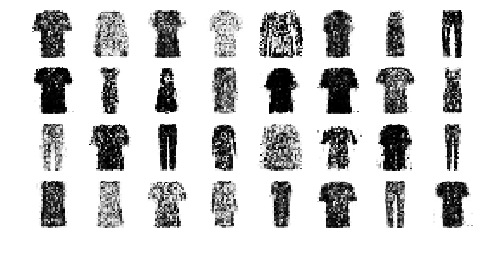

Epoch 45/50


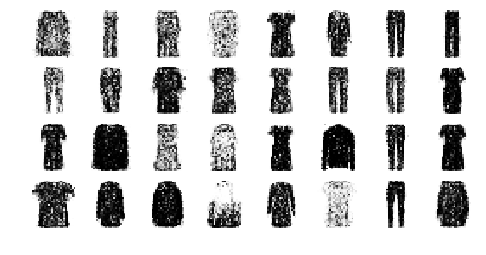

Epoch 46/50


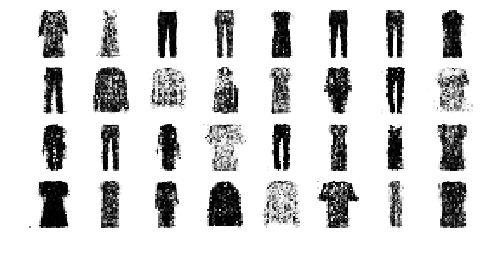

Epoch 47/50


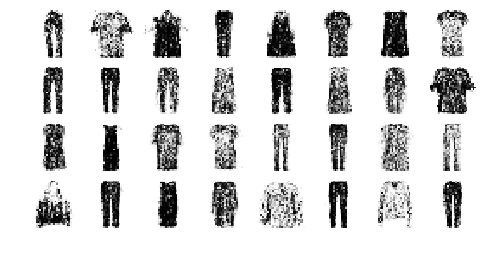

Epoch 48/50


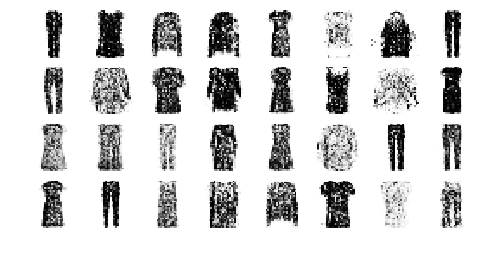

Epoch 49/50


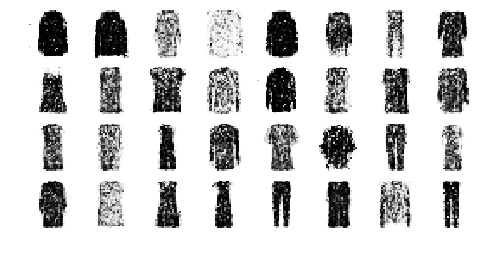

Epoch 50/50


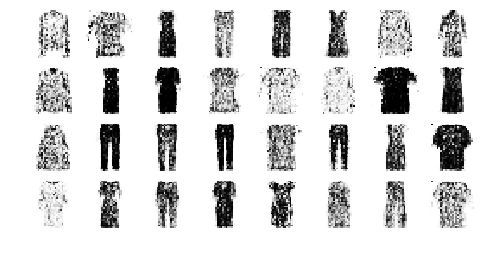

In [60]:
train_gan(gan, dataset, batch_size, codings_size)

## The Difficulties of Training GANs

* The biggest difficulty is called mode collapse
* this is when the generator’s outputs gradually become less diverse(OR One common cause of failure in training GANs is when the generator gets stuck in a small subspace and learns to generate similar samples. 
* The GAN may gradually cycle across a few classes, never really becoming very good at any of them.

## Deep Convolutional GANs (DCGANs)

***main guidelines***

* Replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).
* Use Batch Normalization in both the generator and the discriminator, except in the generator’s output layer and the discriminator’s input layer.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in the generator for all layers except the output layer, which should use tanh.
* Use leaky ReLU activation in the discriminator for all layers.
* you may still need to experiment with different hyperparameters


***The generator***

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    
    # takes codings of size 100, and it projects them to 6272 dimensions (7 *7 * 128)
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    
    # reshapes the result to get a 7 × 7 × 128 tensor.
    keras.layers.Reshape([7, 7, 128]),
    
    # This tensor is batch normalized
    keras.layers.BatchNormalization(),
    
    # fed to a transposed convolutional layer with a stride of 2, 
    # which upsamples it from 7 × 7 to 14 × 14 and reduces its depth from 128 to 64.
    # This layer uses the selu activation function.
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    
    # The result is batch normalized again
    keras.layers.BatchNormalization(),
    
    # fed to another transposed convolutional layer with a stride of 2, 
    # which upsamples it from 14 × 14 to 28 × 28 and reduces the depth from 64 to 1. 
    # This layer uses the tanh activation function, so the outputs will range from –1 to 1.
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

generator.build()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 6272)              633472    
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                     

***Discriminator***

* like a regular CNN for binary classification
* instead of using max pooling layers to downsample the image, we use strided convolutions (strides=2)
* use the leaky ReLU activation function


In [25]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.build()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_23 (Dense)            (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-t

In [26]:
gan = keras.models.Sequential([generator, discriminator])
gan.build()
gan.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 28, 28, 1)         840705    
                                                                 
 sequential_11 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 1,053,186
Non-trainable params: 384
_________________________________________________________________


In [27]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [28]:
# scale them by a factor of 2 and shift them by –1 such that
# the pixel intensities will be rescaled to be in the range [–1, 1]

X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

* build the dataset, then compile and train this model

In [29]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


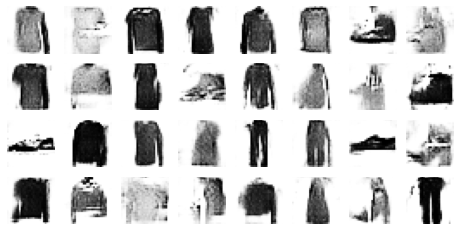

Epoch 2/50


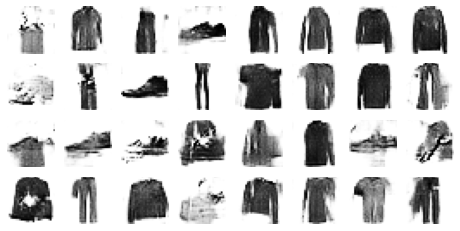

Epoch 3/50


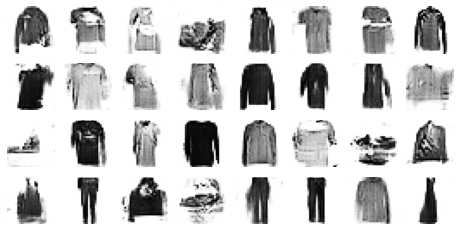

Epoch 4/50


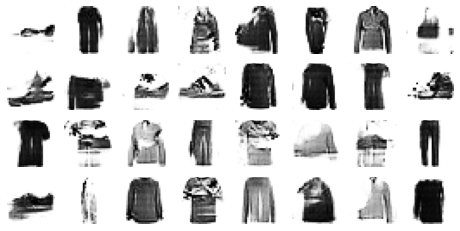

Epoch 5/50


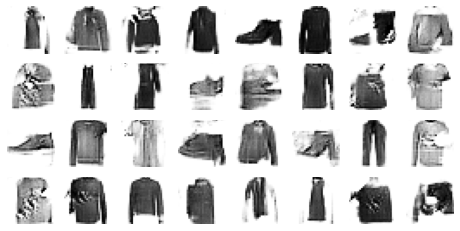

Epoch 6/50


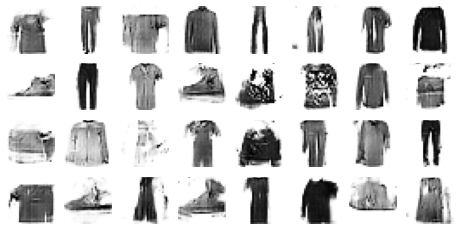

Epoch 7/50


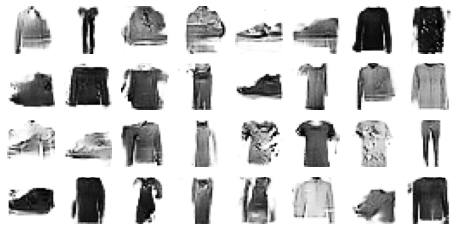

Epoch 8/50


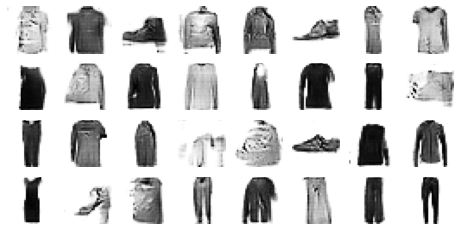

Epoch 9/50


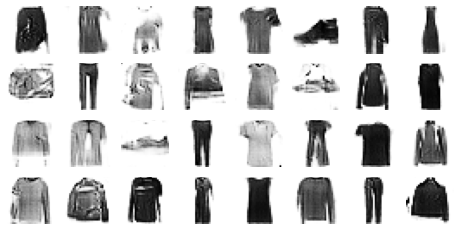

Epoch 10/50


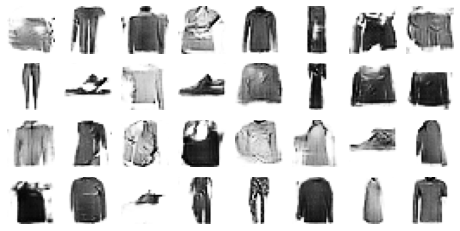

Epoch 11/50


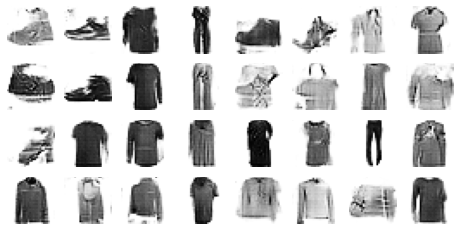

Epoch 12/50


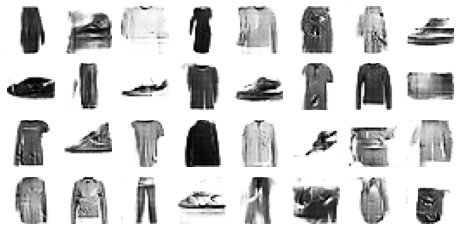

Epoch 13/50


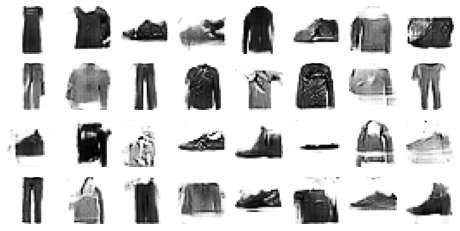

Epoch 14/50


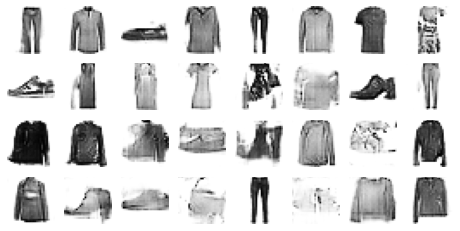

Epoch 15/50


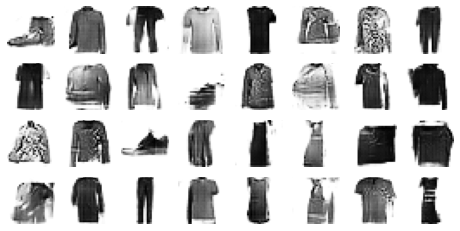

Epoch 16/50


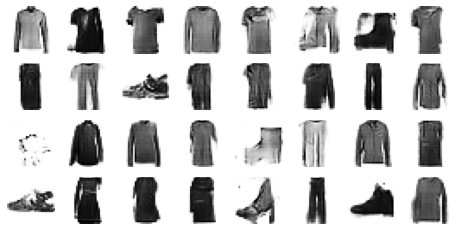

Epoch 17/50


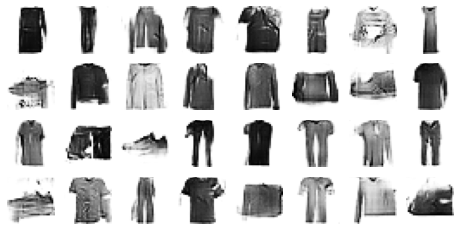

Epoch 18/50


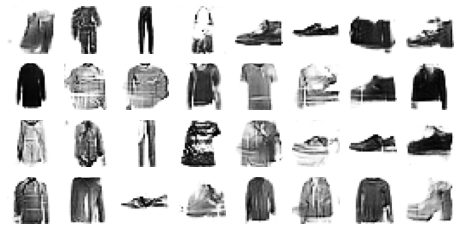

Epoch 19/50


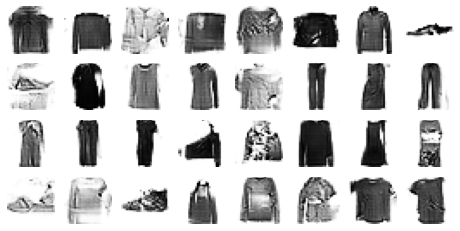

Epoch 20/50


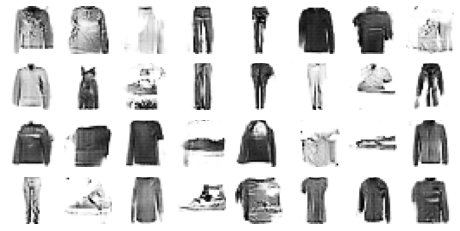

Epoch 21/50


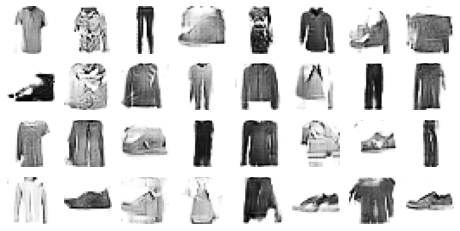

Epoch 22/50


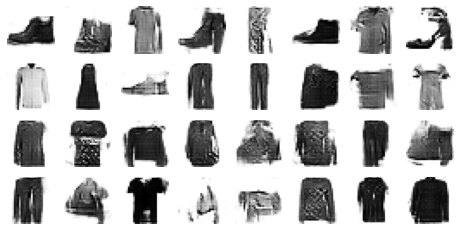

Epoch 23/50


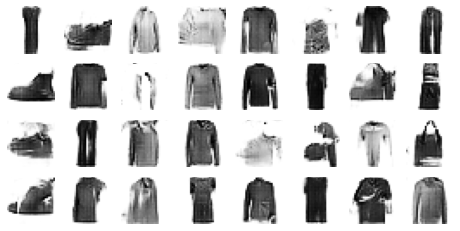

Epoch 24/50


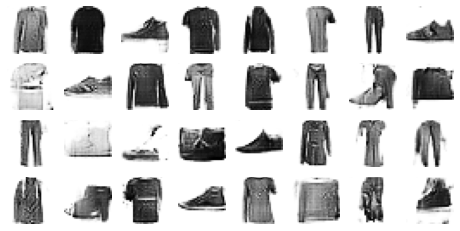

Epoch 25/50


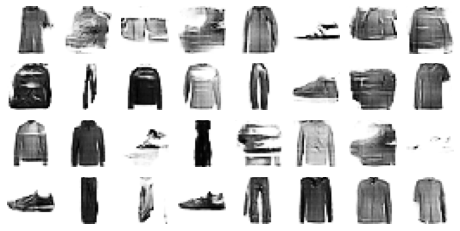

Epoch 26/50


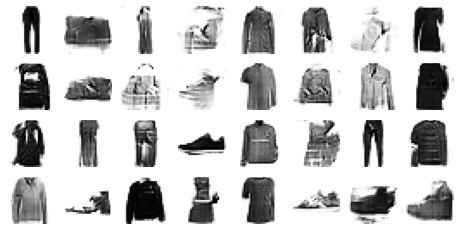

Epoch 27/50


In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

### Generating Fashion MNIST Images

Saving figure dcgan_generated_images_plot


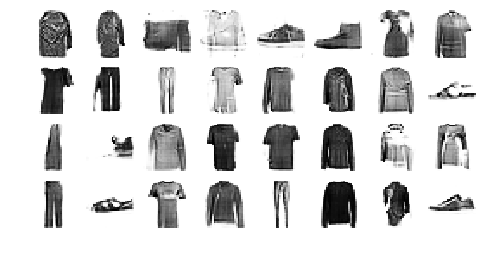

In [66]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
# save_fig("dcgan_generated_images_plot", tight_layout=False)